In [1]:
#!/usr/bin/env python
import os
import sys
import timeit
import warnings

make_gal_cat_path = os.path.expanduser("~/Lensing/GitHub/mass_calibration_of_DM_halos/projection/mini_uchuu_cylinder_richness_scripts")
sys.path.append(make_gal_cat_path)
# You can add the specific imports from the modules you are using in the local directory.
from arg_parser_utils import parse_arguments
from fid_hod import Ngal_S20_poisson

# Third-party libraries
import numpy as np
import pandas as pd
import h5py
from scipy.interpolate import interp1d
from scipy.special import erf
from halotools.empirical_models import (TrivialPhaseSpace, NFWPhaseSpace,
                                        HodModelFactory, OccupationComponent)
from halotools.sim_manager import UserSuppliedHaloCatalog
from halotools.custom_exceptions import HalotoolsError
from colossus.cosmology import cosmology
from colossus.halo import concentration

from scipy import spatial
import glob
import fitsio
import yaml
from astropy.io import fits

import timeit
from concurrent.futures import ProcessPoolExecutor
from astropy.table import Table
from joblib import Parallel, delayed
from tqdm import tqdm
import itertools
from astropy.cosmology import FlatLambdaCDM
import uuid
import argparse

In [2]:
parser = argparse.ArgumentParser()
parser.add_argument('--pec_vel', action='store_true', help="Set to True to consider peculiar velocities.")
#     parser.add_argument('--los', type=str, default='z', choices=['x', 'y', 'z'], help="Line-of-sight direction. Default is 'z'.")
parser.add_argument('--new', action='store_true', help="Use new satellite HOD method.")
parser.add_argument('--alpha', type=float, default=1.0, help='Slope of satellite occupation power law')
parser.add_argument('--logM_min', type=float, default=12.0, help='Minimum halo mass to host a central')
parser.add_argument('--sigma_logM', type=float, default=0.6, help='Width of central transition')
parser.add_argument('--logM0', type=float, default=11.7, help='Satellite cut-off mass')
parser.add_argument('--logM1', type=float, default=12.9, help='Minimum halo mass to host a satellite')
parser.add_argument('--f_cen', type=float, default=0.6, help='Central incompleteness fraction')
# parser.add_argument('--yml_file', type=str, default='/bsuhome/tnde/Lensing/codes/notebooks/mini_uchuu/mini_uchuu_fid_hod.yml', help='Path to the YAML file')

parser.add_argument('--redshift', type=float, default=0.3, help='Specify redshift')
parser.add_argument('--h', type=float, default=0.6774, help='Specify reduced Hubble constant')
parser.add_argument('--Ob', type=float, default=0.0486, help='Specify cosmo baryon density parameter, \Omega_b')
parser.add_argument('--Om', type=float, default=0.3089, help='Specify cosmo mass density parameter, \Omega_m')
parser.add_argument('--ns', type=float, default=0.9667, help='Specify spectral index of the scalar power spectrum, n_s')
parser.add_argument('--sigma8', type=float, default=0.8159, help='Specify root mean square of the amplitude of matter (perturbations) power spectrum averaged over spheres of 8 Mpc/h radius, \sigma_8')
parser.add_argument('--nbody_loc', type=str, default='/bsuhome/hwu/scratch/uchuu/MiniUchuu/')
parser.add_argument('--output_loc', type=str, default='/bsuscratch/tnde/MiniUchuu_mock_d30_no_pecvel_final_changing_vol_heidi_final9/HOD_z0.3_None_joblib_new')
parser.add_argument('--model_name', type=str, default='fid_hod_z0.3')
parser.add_argument('--nbody', type=str, default='mini_uchuu')

parser.add_argument('--seed', type=int, default=42, help='Random seed')
parser.add_argument('--depth', type=float, default=30.0, help='Optional: Override depth from the YAML file')
parser.add_argument('--los', type=str, default='z', choices=['x', 'y', 'z'], help="Line-of-sight direction. Default is 'z'.")
# parser.add_argument('--new', action='store_true', help="Use new dataset.")
parser.add_argument('--suffix', type=str, default=None, help="Suffix for fitting methods, simul: simultaneous fit for both sigma_logM and logM_min; sigma_#: sigma_logM is fixed as #.")
args = parser.parse_args([])
# args = parse_arguments()

In [3]:
# conda install -c conda-forge halotools

In [4]:
start = timeit.default_timer()

from periodic_boundary_condition import periodic_boundary_condition
from periodic_boundary_condition import periodic_boundary_condition_halos

new_prefix = 'new_' if args.new else ''

# with open(args.yml_file, 'r') as stream:
#     try:
#         para = yaml.safe_load(stream)
#     except yaml.YAMLError as exc:
#         print(exc)

# If depth is provided from the command line, use it. Otherwise, use the value from the YAML file.
depth = args.depth if args.depth is not None else 30.0
pec_vel = args.pec_vel
# pec_vel = True #add peculiar velocities.
suffix = args.suffix if args.suffix is not None else None

if pec_vel:
    rich_name = f'd{depth}_pecvel'
else:
    rich_name = f'd{depth}'

redshift = args.redshift
perc = True
use_rlambda = True
use_pmem = False
los = args.los

save_members = True
sat_from_part = False

print('use pmem:', use_pmem)
print('pec vel:', pec_vel)
print('sat from part:', sat_from_part)

Mmin = 10**12.5

n_parallel_z = 1 # NOTE! cannot do more than one yet.
n_parallel_x = 10 # TODO: check n_parallel_x != n_parallel_y
n_parallel_y = 10

n_parallel = n_parallel_z * n_parallel_x * n_parallel_y

# z_padding_halo = 0
# z_padding_gal = 0

output_loc = args.output_loc
model_name = args.model_name

model_suffix = f"d{args.depth}"
if args.pec_vel:
    model_suffix += "_pecvel"

if pec_vel:
    prefix = '_pecvel'
else:
    prefix = ''

# output_loc = para['output_loc']
os.makedirs(output_loc, exist_ok=True)

if suffix is None:
    out_path = f'{output_loc}/model_{model_name}_{model_suffix}/'
else:
    out_path = f'{output_loc}/model_{model_name}_{model_suffix}_{suffix}/'
    
if not os.path.isdir(out_path):
    os.makedirs(out_path)
if not os.path.isdir(f'{out_path}/temp/'):
    os.makedirs(f'{out_path}/temp/')

# read in halos

from read_mini_uchuu import ReadMiniUchuu
readcat = ReadMiniUchuu(args.nbody_loc, redshift)

# if para['nbody'] == 'uchuu':
#     from read_uchuu import ReadUchuu
#     readcat = ReadUchuu(para['nbody_loc'], redshift)

# if para['nbody'] == 'abacus_summit':
#     sys.path.append('../abacus_summit')
#     from read_abacus_summit import ReadAbacusSummit
#     readcat = ReadAbacusSummit(para['nbody_loc'], redshift)

# if para['nbody'] == 'tng_dmo':
#     from read_tng_dmo import ReadTNGDMO
#     halofinder = para.get('halofinder', 'rockstar')
#     readcat = ReadTNGDMO(para['nbody_loc'], halofinder, redshift)
#     print('halofinder', halofinder)

boxsize = readcat.boxsize
OmegaM = readcat.OmegaM
hubble = readcat.hubble
readcat.read_halos(Mmin, pec_vel=pec_vel)
hid_in = readcat.hid
# mass_in = readcat.mass
mass_in = readcat.mass_200m

OmegaDE = 1 - OmegaM
Ez = np.sqrt(OmegaM * (1+redshift)**3 + OmegaDE)

if los == 'z':
    x_halo_in = readcat.xh
    y_halo_in = readcat.yh
    z_halo_in = readcat.zh
    if pec_vel == True:
        z_halo_in += (1+redshift) * readcat.vz / Ez / 100.
if los == 'x':
    x_halo_in = readcat.yh
    y_halo_in = readcat.zh
    z_halo_in = readcat.xh
    if pec_vel == True:
        z_halo_in += (1+redshift) * readcat.vx / Ez / 100.
if los == 'y':
    x_halo_in = readcat.zh
    y_halo_in = readcat.xh
    z_halo_in = readcat.yh
    if pec_vel == True:
        z_halo_in += (1+redshift) * readcat.vy / Ez / 100.

del readcat

if use_pmem == True:
    use_cylinder = False
    which_pmem = False
    if which_pmem == 'myles3':
        from pmem_weights_myles3 import pmem_weights
    if which_pmem == 'buzzard':
        from pmem_weights_buzzard import pmem_weights

    depth = -1
    dz_max = 0.5 * boxsize * Ez / 3000. # need to be smaller than half box size, otherwise the same galaxies will be counted twice
    print('dz_max', dz_max)
else:
    use_cylinder = True

scale_factor = 1./(1.+redshift)

#######################
seed = args.seed
# np.random.seed(seed=seed) # for scipy
#######################

# read in galaxies
gal_cat_format = 'fits'

if gal_cat_format == 'fits':
    if suffix is None:
        gal_fname = f'{output_loc}/model_{model_name}/{new_prefix}gals_seed{seed}.fit'
    else:
        gal_fname = f'{output_loc}/model_{model_name}/{new_prefix}gals_{suffix}_seed{seed}.fit'
    with fits.open(gal_fname) as hdul:
        data = hdul[1].data  # Assuming the data is in the first extension
        header = hdul[1].header
        if los == 'z':
            x_gal_in = data['px']
            y_gal_in = data['py']
            z_gal_in = data['pz']
            if pec_vel:
                z_gal_in += (1+redshift) * data['vz'] / Ez / 100.
        if los == 'x':
            x_gal_in = data['py']
            y_gal_in = data['pz']
            z_gal_in = data['px']
            if pec_vel:
                z_gal_in += (1+redshift) * data['vx'] / Ez / 100.
        if los == 'y':
            x_gal_in = data['pz']
            y_gal_in = data['px']
            z_gal_in = data['py']
            if pec_vel:
                z_gal_in += (1+redshift) * data['vy'] / Ez / 100.

#### periodic boundary condition ####
# x_padding = 3
# y_padding = 3
if los == 'z':
    x_padding, y_padding, z_padding = 3, 3, 0
elif los == 'x':
    x_padding, y_padding, z_padding = 0, 3, 3
elif los == 'y':
    x_padding, y_padding, z_padding = 3, 0, 3

# x_halo, y_halo, z_halo, hid, mass = periodic_boundary_condition_halos(
#     x_halo_in, y_halo_in, z_halo_in, 
#     boxsize, x_padding, y_padding, 0, hid_in, mass_in)

x_halo, y_halo, z_halo, hid, mass = periodic_boundary_condition_halos(
    x_halo_in, y_halo_in, z_halo_in, 
    boxsize, x_padding, y_padding, z_padding, hid_in, mass_in)

sort = np.argsort(-mass)
hid = hid[sort]
mass = mass[sort]
x_halo = x_halo[sort]
y_halo = y_halo[sort]
z_halo = z_halo[sort]

# x_gal, y_gal, z_gal = periodic_boundary_condition(
#     x_gal_in, y_gal_in, z_gal_in,
#     boxsize, x_padding, y_padding, 0)

x_gal, y_gal, z_gal = periodic_boundary_condition(
    x_gal_in, y_gal_in, z_gal_in,
    boxsize, x_padding, y_padding, z_padding)

class CalcRichness(object): # one pz slice at a time
    def __init__(self, pz_min, pz_max, px_min=0, px_max=boxsize, py_min=0, py_max=boxsize):
        self.pz_min = pz_min
        self.pz_max = pz_max
        self.px_min = px_min
        self.px_max = px_max
        self.py_min = py_min
        self.py_max = py_max

#         sel_gal = (z_gal > pz_min - z_padding_gal) & (z_gal < pz_max + z_padding_gal)
        sel_gal = (z_gal > pz_min - z_padding) & (z_gal < pz_max + z_padding)
        if px_min > 0 or px_max < boxsize or py_min > 0 or py_max < boxsize: # further dicing the pz slice
            sel_gal &= (x_gal > px_min - x_padding) & (x_gal < px_max + x_padding)
            sel_gal &= (y_gal > py_min - y_padding) & (y_gal < py_max + y_padding)

        self.x_gal = x_gal[sel_gal]
        self.y_gal = y_gal[sel_gal]
        self.z_gal = z_gal[sel_gal]
        
#         sel_halo = (z_halo > pz_min - z_padding_halo) & (z_halo < pz_max + z_padding_halo)
        sel_halo = (z_halo > pz_min - z_padding) & (z_halo < pz_max + z_padding)
        if px_min > 0 or px_max < boxsize or py_min > 0 or py_max < boxsize:
            sel_halo &= (x_halo > px_min - x_padding) & (x_halo < px_max + x_padding)
            sel_halo &= (y_halo > py_min - y_padding) & (y_halo < py_max + y_padding)

        self.x_halo = x_halo[sel_halo]
        self.y_halo = y_halo[sel_halo]
        self.z_halo = z_halo[sel_halo]
        self.hid = hid[sel_halo]
        self.mass = mass[sel_halo]

        #### sort again, just to be safe ####
        sort = np.argsort(-self.mass)
        self.hid = self.hid[sort]
        self.mass = self.mass[sort]
        self.x_halo = self.x_halo[sort]
        self.y_halo = self.y_halo[sort]
        self.z_halo = self.z_halo[sort]

        gal_position = np.dstack([self.x_gal, self.y_gal])[0]
        gal_tree = spatial.cKDTree(gal_position)

        halo_position = np.dstack([self.x_halo, self.y_halo])[0]
        halo_tree = spatial.cKDTree(halo_position)

        rmax_tree = 2
        self.indexes_tree = halo_tree.query_ball_tree(gal_tree, r=rmax_tree)
        self.gal_taken = np.zeros(len(self.x_gal)) # for percolation

    def get_richness(self, i_halo):
        gal_ind = self.indexes_tree[i_halo]
        x_cen = self.x_halo[i_halo]
        y_cen = self.y_halo[i_halo]
        z_cen = self.z_halo[i_halo]

        #### step 1: cut the LOS ####
        z_gal_gal_ind = self.z_gal[gal_ind]
        d_pbc0 = z_gal_gal_ind - z_cen
        d_pbc1 = z_gal_gal_ind + boxsize - z_cen
        d_pbc2 = z_gal_gal_ind - boxsize - z_cen

        dz0 = d_pbc0 * Ez / 3000.
        dz1 = d_pbc1 * Ez / 3000.
        dz2 = d_pbc2 * Ez / 3000.

        if use_cylinder == True and depth > 0:
            sel_z0 = (np.abs(d_pbc0) < depth)
            sel_z1 = (np.abs(d_pbc1) < depth)
            sel_z2 = (np.abs(d_pbc2) < depth)
            sel_z = sel_z0 | sel_z1 | sel_z2
            sel_z = sel_z & (self.gal_taken[gal_ind] < 1e-4)
            dz0 = dz0[sel_z]
            dz1 = dz1[sel_z]
            dz2 = dz2[sel_z]

        elif use_pmem == True and depth == -1:
            sel_z0 = (np.abs(dz0) < dz_max)
            sel_z1 = (np.abs(dz1) < dz_max)
            sel_z2 = (np.abs(dz2) < dz_max)
            sel_z = sel_z0 | sel_z1 | sel_z2
            sel_z = sel_z & (self.gal_taken[gal_ind] < 0.8) # TODO: percolation threshold?
            dz0 = dz0[sel_z]
            dz1 = dz1[sel_z]
            dz2 = dz2[sel_z]

        else:
            print('BUG!!')

        #### step 2: calculate radius ####
        r = (self.x_gal[gal_ind][sel_z] - x_cen)**2 + (self.y_gal[gal_ind][sel_z] - y_cen)**2 
        r = np.sqrt(r)

        #### step 3: iteratively calculating r_lambda ####
        if use_rlambda == True:
            rlam_ini = 1
            rlam = rlam_ini
            for iteration in range(100):
                if use_cylinder == True and depth > 0:
                    ngal = len(r[r < rlam])
                elif use_pmem == True or depth == -1:
                    pmem0 = pmem_weights(dz0, r/rlam, dz_max=dz_max)
                    pmem1 = pmem_weights(dz1, r/rlam, dz_max=dz_max)
                    pmem2 = pmem_weights(dz2, r/rlam, dz_max=dz_max)
                    pmem = pmem0 + pmem1 + pmem2
                    ngal = np.sum(pmem)
                else:
                    print('BUG!!')

                rlam_old = rlam
                rlam = (ngal/100.)**0.2 / scale_factor # phys -> comoving
                if abs(rlam - rlam_old) < 1e-5 or rlam < 1e-6:
                    break
        else: 
            rlam = radius # fixed aperture

        #### Step 4: do percolation ####
        if rlam > 0:
            sel_mem = (r < rlam)
            if perc == True and len(gal_ind) > 0:
                if use_cylinder == True:
                    self.gal_taken[np.array(gal_ind)[sel_z][sel_mem]] = 1
                if use_pmem == True: # probabilistic percolation
                    self.gal_taken[np.array(gal_ind)[sel_z][sel_mem]] += pmem[sel_mem]

        #### Step 5 (optional): save the member galaxies ####
        if save_members == True:
            if rlam > 0:
                if use_cylinder == True and depth > 0: # no repeat
                    self.x_gal_mem = self.x_gal[gal_ind][sel_z][sel_mem]
                    self.y_gal_mem = self.y_gal[gal_ind][sel_z][sel_mem]
                    self.z_gal_mem = self.z_gal[gal_ind][sel_z][sel_mem]
                    dz_all = np.array([dz0[sel_mem], dz1[sel_mem], dz2[sel_mem]])
                    arg = np.array([np.argmin(np.abs(dz_all), axis=0)]) # find the smallest absolute value
                    self.dz_out = np.take_along_axis(dz_all, arg, axis=0) # cool numpy function!
                    self.dz_out = np.concatenate(self.dz_out)
                    self.r_out = r[sel_mem]/rlam 
                    self.p_gal_mem = self.x_gal_mem * 0 + 1
                    self.pmem_out = self.x_gal_mem * 0 + 1

                elif use_pmem == True or depth == -1: # each gal: repeat 3 times for PBC
                    self.x_gal_mem = np.tile(self.x_gal[gal_ind][sel_z][sel_mem], 3)
                    self.y_gal_mem = np.tile(self.y_gal[gal_ind][sel_z][sel_mem], 3)
                    self.z_gal_mem = np.tile(self.z_gal[gal_ind][sel_z][sel_mem], 3)
                    # save duplicate galaxies for dz0, dz1, and dz2
                    self.dz_out = np.concatenate([dz0[sel_mem], dz1[sel_mem], dz2[sel_mem]])
                    self.r_out = np.tile(r[sel_mem]/rlam, 3) 
                    self.p_gal_mem = pmem[sel_mem]
                    self.pmem_out = np.concatenate([pmem0[sel_mem], pmem1[sel_mem], pmem2[sel_mem]])
                    
                    sel = (self.pmem_out > 1e-6)
                    self.x_gal_mem = self.x_gal_mem[sel]
                    self.y_gal_mem = self.y_gal_mem[sel]
                    self.z_gal_mem = self.z_gal_mem[sel]
                    self.dz_out = self.dz_out[sel]
                    self.r_out = self.r_out[sel]
                    self.pmem_out = self.pmem_out[sel]

                    if max(self.p_gal_mem) > 1:
                        print('max(self.p_gal_mem)', max(self.p_gal_mem), 'BUG!: double counting galaxies.')
                        exit()
                else:
                    print('BUG')

        return rlam, ngal

    def measure_richness(self):
        nh = len(self.x_halo)

        #### richness files:  ####
        if suffix is None:
            ofname1 = f'{out_path}/temp/{new_prefix}richness_{rich_name}_pz{self.pz_min:.0f}_{self.pz_max:.0f}_px{self.px_min:.0f}_{self.px_max:.0f}_py{self.py_min:.0f}_{self.py_max:.0f}.dat'
        else:
            ofname1 = f'{out_path}/temp/{new_prefix}richness_{rich_name}_{suffix}_pz{self.pz_min:.0f}_{self.pz_max:.0f}_px{self.px_min:.0f}_{self.px_max:.0f}_py{self.py_min:.0f}_{self.py_max:.0f}.dat'
        outfile1 = open(ofname1, 'w')
        outfile1.write('#hid, mass, px, py, pz, rlam, lam \n')

        #### member files: only write header (optional) ####
        if save_members == True:
            if suffix is None:
                ofname2 = f'{out_path}/temp/{new_prefix}members_{rich_name}_pz{self.pz_min:.0f}_{self.pz_max:.0f}_px{self.px_min:.0f}_{self.px_max:.0f}_py{self.py_min:.0f}_{self.py_max:.0f}.dat'
            else:
                ofname2 = f'{out_path}/temp/{new_prefix}members_{rich_name}_{suffix}_pz{self.pz_min:.0f}_{self.pz_max:.0f}_px{self.px_min:.0f}_{self.px_max:.0f}_py{self.py_min:.0f}_{self.py_max:.0f}.dat'
            outfile2 = open(ofname2, 'w')
            outfile2.write('#hid, dz, r/rlam, pmem \n')
            outfile2.close()

        for ih in range(nh):
            rlam, lam = self.get_richness(ih)
            if lam > 0 and \
                self.z_halo[ih] > self.pz_min and self.z_halo[ih] < self.pz_max and \
                self.x_halo[ih] > self.px_min and self.x_halo[ih] < self.px_max and \
                self.y_halo[ih] > self.py_min and self.y_halo[ih] < self.py_max:

                outfile1.write('%12i %15e %12g %12g %12g %12g %12g \n'%(self.hid[ih], self.mass[ih], self.x_halo[ih], self.y_halo[ih], self.z_halo[ih], rlam, lam))

                #### save members (append) (optional) #### 
                if save_members == True:
                    self.dz_out *= 3000. / Ez # convert back to comoving distance
                    self.hid_mem = self.x_gal_mem * 0 + self.hid[ih]
                    data = np.array([self.hid_mem, self.x_gal_mem, self.y_gal_mem, self.z_gal_mem, self.dz_out, self.r_out, self.pmem_out]).transpose()
                    with open(ofname2, "ab") as f:
                        np.savetxt(f, data, fmt='%12i %12g %12g %12g %12g %12g %12g')

        outfile1.close()



z_layer_thickness = boxsize / n_parallel_z
x_cube_size = boxsize / n_parallel_x
y_cube_size = boxsize / n_parallel_y

def calc_one_bin(ibin):
    iz = ibin // (n_parallel_x * n_parallel_y)
    ixy = ibin % (n_parallel_x * n_parallel_y)
    ix = ixy // n_parallel_x
    iy = ixy % n_parallel_x
    pz_min = iz*z_layer_thickness
    pz_max = (iz+1)*z_layer_thickness
    px_min = ix*x_cube_size
    px_max = (ix+1)*x_cube_size
    py_min = iy*y_cube_size
    py_max = (iy+1)*y_cube_size

    if suffix is None:
        ofname = f'{out_path}/temp/{new_prefix}richness_{rich_name}_pz{pz_min:.0f}_{pz_max:.0f}_px{px_min:.0f}_{px_max:.0f}_py{py_min:.0f}_{py_max:.0f}.dat'
    else:
        ofname = f'{out_path}/temp/{new_prefix}richness_{rich_name}_{suffix}_pz{pz_min:.0f}_{pz_max:.0f}_px{px_min:.0f}_{px_max:.0f}_py{py_min:.0f}_{py_max:.0f}.dat'

    if os.path.exists(ofname) == False:
        cr = CalcRichness(pz_min=pz_min, pz_max=pz_max, px_min=px_min, px_max=px_max, py_min=py_min, py_max=py_max)
        cr.measure_richness()

def merge_files_richness():
    if suffix is None:
        fname_list = glob.glob(f'{out_path}/temp/{new_prefix}richness_{rich_name}_pz*.dat')
    else:
        fname_list = glob.glob(f'{out_path}/temp/{new_prefix}richness_{rich_name}_{suffix}_pz*.dat')
    nfiles = len(fname_list)
    if nfiles < n_parallel:
        print('missing ', n_parallel - nfiles, 'files, not merging')
    else:
        hid_out = []
        m_out = []
        x_out = []
        y_out = []
        z_out = []
        rlam_out = []
        lam_out = []

        for fname in fname_list:
            data = pd.read_csv(fname, delim_whitespace=True, dtype=np.float64, comment='#', 
                            names=['haloid', 'mass', 'px', 'py', 'pz', 'rlam', 'lam'])
            hid_out.extend(data['haloid'])
            m_out.extend(data['mass'])
            x_out.extend(data['px'])
            y_out.extend(data['py'])
            z_out.extend(data['pz'])
            rlam_out.extend(data['rlam'])
            lam_out.extend(data['lam'])
            
        hid_out = np.array(hid_out)
        m_out = np.array(m_out)
        x_out = np.array(x_out)
        y_out = np.array(y_out)
        z_out = np.array(z_out)
        rlam_out = np.array(rlam_out)
        lam_out = np.array(lam_out)

        sel = np.argsort(-m_out)

        cols = [
            fits.Column(name='haloid', format='K' ,array=hid_out[sel]),
            fits.Column(name='M200m', format='E',array=m_out[sel]),
            # fits.Column(name='Mvir', format='E',array=m_out[sel]),
            fits.Column(name='px', format='D' ,array=x_out[sel]),
            fits.Column(name='py', format='D',array=y_out[sel]),
            fits.Column(name='pz', format='D',array=z_out[sel]),
            fits.Column(name='Rlambda', format='D',array=rlam_out[sel]),
            fits.Column(name='lambda', format='D',array=lam_out[sel]),
        ]
        coldefs = fits.ColDefs(cols)
        tbhdu = fits.BinTableHDU.from_columns(coldefs)
        if suffix is None:
            tbhdu.writeto(f'{out_path}/{new_prefix}richness_{rich_name}.fit', overwrite=True)
            os.system(f'rm -rf {out_path}/temp/{new_prefix}richness_{rich_name}_pz*.dat')
        else:
            tbhdu.writeto(f'{out_path}/{new_prefix}richness_{rich_name}_{suffix}.fit', overwrite=True)
            os.system(f'rm -rf {out_path}/temp/{new_prefix}richness_{rich_name}_{suffix}_pz*.dat')

def merge_files_members():
    if suffix is None:
        fname_list = glob.glob(f'{out_path}/temp/{new_prefix}members_{rich_name}_pz*.dat')
    else:
        fname_list = glob.glob(f'{out_path}/temp/{new_prefix}members_{rich_name}_{suffix}_pz*.dat')
    nfiles = len(fname_list)
    if nfiles < n_parallel:
        print('missing ', n_parallel - nfiles, 'files, not merging')
    else:
        print('nfiles', nfiles)
        hid_out = []
        x_out = []
        y_out = []
        z_out = []
        dz_out = []
        r_out = []
        pmem_out = []

        for fname in fname_list:
            data = pd.read_csv(fname, delim_whitespace=True, dtype=np.float64, comment='#', 
                            names=['haloid', 'px', 'py', 'pz', 'dz', 'r', 'pmem'])
            hid_out.extend(data['haloid'])
            x_out.extend(data['px'])
            y_out.extend(data['py'])
            z_out.extend(data['pz'])
            dz_out.extend(data['dz'])
            r_out.extend(data['r'])
            pmem_out.extend(data['pmem'])
            
        hid_out = np.array(hid_out)
        x_out = np.array(x_out)
        y_out = np.array(y_out)
        z_out = np.array(z_out)
        dz_out = np.array(dz_out)
        r_out = np.array(r_out)
        pmem_out = np.array(pmem_out)

        cols = [
            fits.Column(name='haloid', format='K' ,array=hid_out),
            fits.Column(name='px_gal', format='D' ,array=x_out),
            fits.Column(name='py_gal', format='D',array=y_out),
            fits.Column(name='pz_gal', format='D',array=z_out),
            fits.Column(name='dz_gal', format='D',array=dz_out),
            fits.Column(name='r_over_rlambda', format='D',array=r_out),
            fits.Column(name='pmem', format='D',array=pmem_out),
        ]
        coldefs = fits.ColDefs(cols)
        tbhdu = fits.BinTableHDU.from_columns(coldefs)
        if suffix is None:
            tbhdu.writeto(f'{out_path}/{new_prefix}members_{rich_name}.fit', overwrite=True)
            os.system(f'rm -rf {out_path}/temp/{new_prefix}members_{rich_name}_pz*.dat')
        else:
            tbhdu.writeto(f'{out_path}/{new_prefix}members_{rich_name}_{suffix}.fit', overwrite=True)
            os.system(f'rm -rf {out_path}/temp/{new_prefix}members_{rich_name}_{suffix}_pz*.dat')


if __name__ == '__main__':
    #calc_one_bin(0)
    
    stop = timeit.default_timer()
    print('calc_richness.py prep took', '%.2g'%((stop - start)/60), 'mins')
    start = stop
    
    n_cpu = 4 #os.cpu_count()
    n_repeat = int(np.ceil(n_parallel/n_cpu))
    for i_repeat in range(n_repeat):
        with ProcessPoolExecutor() as pool:
            for result in pool.map(calc_one_bin, range(i_repeat*n_cpu, min(n_parallel, (i_repeat+1)*n_cpu))):
                if result: print(result)  # output error

    stop = timeit.default_timer()
    print('richness took', '%.2g'%((stop - start)/60), 'mins')
    start = stop

    merge_files_richness()
    if save_members == True:
        merge_files_members()

    stop = timeit.default_timer()
    print('merging took', '%.2g'%((stop - start)/60), 'mins')
    


use pmem: False
pec vel: False
sat from part: False
calc_richness.py prep took 0.023 mins
richness took 0.48 mins
nfiles 100
merging took 0.025 mins


In [5]:
output_loc = args.output_loc
os.makedirs(output_loc, exist_ok=True)
model_name = args.model_name
box_volume = (400**3)  # in (Mpc/h)^3
cylinder_path = os.path.join(output_loc, f'model_{model_name}_d{depth}/matched_richness_d{depth}{prefix}.fit')

new_prefix = 'new_' if args.new else ''
# If depth is provided from the command line, use it. Otherwise, use the value from the YAML file.
depth = args.depth if args.depth is not None else 30.0
pec_vel = args.pec_vel
# pec_vel = True #add peculiar velocities.
# suffix = args.suffix if args.suffix is not None else None

redshift = args.redshift

output_loc = args.output_loc
model_name = args.model_name

model_suffix = f"d{args.depth}"
if args.pec_vel:
    model_suffix += "_pecvel"

if pec_vel:
    prefix = '_pecvel'
else:
    prefix = ''

# output_loc = para['output_loc']
os.makedirs(output_loc, exist_ok=True)

box_volume = (400**3)  # in (Mpc/h)^3
cylinder_path = os.path.join(output_loc, f'model_{model_name}_d{depth}/matched_richness_d{depth}{prefix}.fit')


def save_fits_data(original_path, table):
    # Save to a new file
    # table.write(original_path.replace('.fit', f'_redMaPPer_lg20_{z_min}{z_max}.fit'), format='fits', overwrite=True)
    table.write(original_path.replace('.fit', f'_redMaPPer_lg20.fit'), format='fits', overwrite=True)
    
# Load the RedMapper data
def load_fits_data_table(path):
    with fits.open(path) as f:
        table = Table(f[1].data)
    return table

def process_combination(depth, model_name, prefix):

    cylinder_path = os.path.join(output_loc, f'model_{model_name}_d{depth}/richness_d{depth}{prefix}.fit')
    cylinder_data = load_fits_data_table(cylinder_path)
    
    lambda_bins = [20, 30, 45, 60, 999]
    redmapper_counts, _ = np.histogram(filtered_redmapper_data['lambda'].data, bins=lambda_bins)
    # print(redmapper_counts)
    
    redmapper_bins = [(20, 30), (30, 45), (45, 60), (60, 999)]
    redmapper_bins.reverse()
    redmapper_counts = redmapper_counts[::-1]
    # print(redmapper_counts)
    redmapper_num_density = redmapper_counts/redmapper_com_vol
    # print(redmapper_num_density)
    cylinder_data['lambda_weighted'] = np.round(cylinder_data['lambda'].astype(float), 1)
    cylinder_counts = np.rint(redmapper_num_density * box_volume).astype(int)
    print('cylinder_counts', cylinder_counts)

    # Get a permutation of indices
    permuted_indices = np.random.permutation(len(cylinder_data['lambda']))
    cylinder_data = cylinder_data[permuted_indices]

    # Sort cylinder data based on richness for easier processing
    sorted_indices = np.argsort(cylinder_data['lambda'])
    sorted_lambda = cylinder_data['lambda'][sorted_indices]

    upper_bound = sorted_lambda.max()  # Set initial upper_bound

    for target_count, target_bin in zip(cylinder_counts, redmapper_bins):
        # Select clusters with highest richness until we match the target_count
        selected_clusters = sorted_lambda[-target_count:]
        
        cylinder_data['lambda_weighted'][sorted_indices[-target_count:]] = target_bin[0]+1
        
        # Define the lower bound for this bin
        lower_bound = selected_clusters.min()
        
        indices_to_remove = sorted_indices[-target_count:]
        print(len(indices_to_remove))
        # Remove the clusters accounted for in this bin
        sorted_indices = sorted_indices[:-target_count]
        sorted_lambda = sorted_lambda[:-target_count]

        # Update the upper bound for the next bin
        upper_bound = lower_bound
        
    # Remove unmatched clusters
    cylinder_data.remove_rows(sorted_indices)
    return cylinder_data

redmapper_path = '/bsuscratch/shuleicao/Cardinalv3/redmapper_v4_v8_v51_y6_v7/run/Cardinal-3Y6a_v2.0_run_run_redmapper_v0.8.1_lgt20_vl02_catalog.fit'
redmapper_data = load_fits_data_table(redmapper_path)
z_bins = [
    {'range': (0.2, 0.35), 'filename': 'zbin1.fit', 'color': 'darkgreen', 'label': r'$z \in [0.2, 0.35)$'},
    {'range': (0.35, 0.5), 'filename': 'zbin2.fit', 'color': 'b', 'label': r'$z \in [0.35, 0.435)$'},
    {'range': (0.5, 0.65), 'filename': 'zbin3.fit', 'color': 'r', 'label': r'$z \in [0.435, 0.57)$'}
]
areas=Table.read('/bsuscratch/shuleicao/Cardinalv3/redmapper_v4_v8_v51_y6_v7/run/Cardinal-3Y6a_v2.0_run_run_redmapper_v0.8.1_weighted_randoms_z010-095_lgt020_vl02_area.fit')
COSMO = FlatLambdaCDM(H0=100*args.h, Om0=args.Om, Ob0=args.Ob, Tcmb0=2.7255, Neff=3.046)

if pec_vel:
    prefix = '_pecvel'
else:
    prefix = ''
    
# for i in range(3):
for i in range(1):
    z_min, z_max = z_bins[i]['range']
    areas_masked=areas[(areas['z']>=z_min)&(areas['z']<z_max)]
    z_area=areas_masked['z']
    area=areas_masked['area']
    area_interpolation = interp1d(z_area, area, kind='linear', fill_value="extrapolate")
    # def dV(z, dz=1e-6):
    #     dA = (area_interpolation(z+dz)-area_interpolation(z)) * (np.pi / 180)**2
    #     dr3 = (COSMO.comoving_distance(z+dz).value*COSMO.h)**3 - (COSMO.comoving_distance(z).value*COSMO.h)**3
    #     return dr3/3 * dA
    def dV(z1, z2):
        A = (area_interpolation(z1)) * (np.pi / 180)**2
        dr3 = (COSMO.comoving_distance(z2).value*COSMO.h)**3 - (COSMO.comoving_distance(z1).value*COSMO.h)**3
        return dr3/3 * A
    # V = 0
    redmapper_com_vol = 0
    dz = 1e-5
    # dz = 1e-4
    z_grid = np.arange(z_min, z_max, dz)
    for z in z_grid:
        # V += dV(z,z+dz)
        redmapper_com_vol += dV(z,z+dz)
    # print(V)
    # print(redmapper_com_vol)
    z_mask = (redmapper_data['z_lambda'] >= z_min) & (redmapper_data['z_lambda'] < z_max)
    filtered_redmapper_data = redmapper_data[z_mask]
    N = len(filtered_redmapper_data)
    # number_density = N/V
    number_density = N/redmapper_com_vol
    label = z_bins[i]['label']
    print(rf'redMaPPer number density in {label} is: {number_density}')
    data = process_combination(depth, model_name, prefix)  
    print('Finished')
    # Save the combined data to the output path
    save_fits_data(cylinder_path, data)

redMaPPer number density in $z \in [0.2, 0.35)$ is: 2.2881060339323676e-06
cylinder_counts [  9   6  27 105]
9
6
27
105
Finished


### View Data

In [1]:
%load_ext autoreload
%autoreload 2
import fitsio
import Corrfunc
import numpy as np
import pandas as pd
from astropy.table import join
from astropy.table import Table
import matplotlib.pyplot as plt
from colossus.halo import concentration
# plt.style.use("CustomizingPlots")
%matplotlib inline

In [2]:
data = Table(fitsio.read(f'/bsuhome/hwu/scratch/uchuu/MiniUchuu/host_halos_043.fit'))
data[:5]

haloid,M200m,Mvir,Rvir,Rs_Klypin,px,py,pz,vx,vy,vz
int64,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64
1530480856,180270000000000.0,167600000000000.0,1224.337,238.925,13.513620000000001,26.971970000000002,18.36326,-64.5,33.94,15.97
1530870209,94671000000000.0,87470000000000.0,985.782,251.99,24.77392,39.24382,48.88203,-31.17,203.73,252.95
1530870315,1782600000000.0,1548000000000.0,256.912,110.624,24.71076,39.716809999999995,50.19775,157.28,160.33,-244.85
1530870357,337160000000.0,325100000000.0,152.689,10.922,24.18005,38.5892,48.43162,-90.83,257.45,491.83
1534058815,98128000000000.0,92680000000000.0,1004.978,114.793,46.78947,36.50805,12.94293,173.12,1.86,-379.5


### Without peculiar velocities

In [3]:
file_path = '/bsuscratch/tnde/MiniUchuu_mock_d30_no_pecvel_final_changing_vol_heidi_final/HOD_z0.3_None_joblib_new/model_fid_hod_z0.3_d30.0/'
matched_richness_d30 =  Table(fitsio.read(file_path+"matched_richness_d30.0_redMaPPer_lg20.fit"))
members_d30 =  Table(fitsio.read(file_path+"members_d30.0.fit "))
# richness_d30 =  Table(fitsio.read(file_path+"richness_d30.0.fit"))
richness_d30 =  Table.read(file_path+"richness_d30.0.fit")
print(matched_richness_d30[:5])
print(members_d30[:5])
richness_d30[:5]

  haloid         M200m          px      py   ... Rlambda lambda lambda_weighted
---------- ----------------- ------- ------- ... ------- ------ ---------------
1546801143 280680000000000.0 202.812 216.521 ... 1.08768   41.0            21.0
1533903886 249530000000000.0 32.7507 367.094 ... 1.08232   40.0            21.0
1545778117 394810000000000.0 174.098 83.9741 ...  1.1535   55.0            21.0
1564305093 388520000000000.0 376.696 217.634 ... 1.19633   66.0            31.0
1545884899 471040000000000.0 170.759 126.276 ... 1.12251   48.0            21.0
  haloid    px_gal  py_gal  pz_gal   dz_gal  r_over_rlambda pmem
---------- ------- ------- ------- --------- -------------- ----
1561344191 324.412 280.563 353.211   1.10334       0.652803  1.0
1561344191 324.585 281.217 352.191 0.0832957       0.337032  1.0
1561344191 325.583 281.382 352.151 0.0430194       0.796423  1.0
1561344191 325.664 281.016 351.912 -0.195483       0.796893  1.0
1561344191 324.185 281.682 352.616  0.508319      

haloid,M200m,px,py,pz,Rlambda,lambda
int64,float32,float64,float64,float64,float64,float64
1563326049,1086000000000000.0,376.424,112.462,144.369,1.2785,92.0
1533818005,968090000000000.0,13.3597,394.406,166.625,1.31275,105.0
1542512774,920630000000000.0,153.485,161.33,303.284,1.31524,106.0
1536439272,841470000000000.0,64.6286,265.028,278.24,1.24941,82.0
1532309382,821330000000000.0,11.1432,223.753,44.125,1.26137,86.0


### With peculiar velocities

In [4]:
# file_path = '/bsuscratch/tnde/MiniUchuu_mock_pec_vel/model_fid_hod_z0.3_d30.0/'
# matched_richness_d30 =  Table(fitsio.read(file_path+"matched_richness_d30.0_pecvel_redMaPPer_lg20.fit"))
# members_d30 =  Table(fitsio.read(file_path+"members_d30.0_pecvel.fit"))
# richness_d30 =  Table(fitsio.read(file_path+"richness_d30.0_pecvel.fit"))
# print(matched_richness_d30[:5])
# print(members_d30[:5])
# richness_d30[:5]

In [5]:
from measure_lensing_v2 import MeasureLensing
from read_mini_uchuu import ReadMiniUchuu

z=0.3
nbody_loc = '/bsuhome/hwu/scratch/uchuu/MiniUchuu/'
rmu = ReadMiniUchuu(nbody_loc, redshift=z)
# xp, yp, zp = matched_richness_d30['px'], matched_richness_d30['py'], matched_richness_d30['pz']
xp, yp, zp = rmu.read_particle_positions()

#### halos ####
rmu.read_halos(Mmin=1e13)
# xh = rmu.xh
# yh = rmu.yh
# zh = rmu.zh
xh, yh, zh = matched_richness_d30['px'], matched_richness_d30['py'], matched_richness_d30['pz']
mass = rmu.mass
boxsize = rmu.boxsize
rhocrit = 2.775e11
OmegaM = rmu.OmegaM
mpart = rhocrit*OmegaM*boxsize**3/len(xp)

# out_loc = 'data/'
ml = MeasureLensing('/bsuhome/tnde/Lensing/data', Rmin=-2, Rmax=2.3, pimax=100)
# ml = MeasureLensing('/bsuhome/tnde/Lensing/data', Rmin=0.0323, Rmax=30, pimax=100)
ml.write_bin_file()

In [6]:
print(len(xh), len(xp))
# 140 16777429 #200m def

147 16777429


In [7]:
# lambda_weighted = matched_richness_d30['lambda_weighted']
# sel0 = (lambda_weighted >= 20)&(lambda_weighted < 30)
# sel1 = (lambda_weighted >= 30)&(lambda_weighted < 45)
# sel2 = (lambda_weighted >= 45)&(lambda_weighted < 60)
# sel3 = lambda_weighted >= 60

# matched_richness_d30[sel3]

In [8]:
richness = matched_richness_d30['lambda_weighted']
true_mass = matched_richness_d30['M200m']
print(len(richness), len(xh))

# Creating richness bins
sel0 = (richness >= 20)&(richness < 30)
sel1 = (richness >= 30)&(richness < 45)
sel2 = (richness >= 45)&(richness < 60)
sel3 = richness >= 60

lam_bin0 = richness[sel0]
lam_bin1 = richness[sel1]
lam_bin2 = richness[sel2]
lam_bin3 = richness[sel3]

print(f'Length of richness bin 1: {len(lam_bin0)}')
print(f'Length of richness bin 2: {len(lam_bin1)}')
print(f'Length of richness bin 3: {len(lam_bin2)}')
print(f'Length of richness bin 4: {len(lam_bin3)}\n')

# mass_true = mass[sel]
mean_mass_true0 = np.mean(true_mass[sel0]) #M_sun
mean_mass_true1 = np.mean(true_mass[sel1])
mean_mass_true2 = np.mean(true_mass[sel2])
mean_mass_true3 = np.mean(true_mass[sel3])

std_arr_true = np.array([np.std(true_mass[sel0]), np.std(true_mass[sel1]), np.std(true_mass[sel2]), np.std(true_mass[sel3])])

print('mean mass 1:', f'{mean_mass_true0:e}')
print('mean mass 2:', f'{mean_mass_true1:e}')
print('mean mass 3:', f'{mean_mass_true2:e}')
print('mean mass 4:', f'{mean_mass_true3:e}\n')

rp_, Sigma0, DeltaSigma0 = ml.measure_lensing(xh[sel0], yh[sel0], zh[sel0], xp, yp, zp, boxsize, mpart)
rp_, Sigma1, DeltaSigma1 = ml.measure_lensing(xh[sel1], yh[sel1], zh[sel1], xp, yp, zp, boxsize, mpart)
rp_, Sigma2, DeltaSigma2 = ml.measure_lensing(xh[sel2], yh[sel2], zh[sel2], xp, yp, zp, boxsize, mpart)
rp_, Sigma3, DeltaSigma3 = ml.measure_lensing(xh[sel3], yh[sel3], zh[sel3], xp, yp, zp, boxsize, mpart)

# rp_, Sigma0, DeltaSigma0 = ml.measure_lensing(xh[sel0], yh[sel0], zh[sel0], xh, yh, zh, boxsize, mpart)
# rp_, Sigma1, DeltaSigma1 = ml.measure_lensing(xh[sel1], yh[sel1], zh[sel1], xh, yh, zh, boxsize, mpart)
# rp_, Sigma2, DeltaSigma2 = ml.measure_lensing(xh[sel2], yh[sel2], zh[sel2], xh, yh, zh, boxsize, mpart)
# rp_, Sigma3, DeltaSigma3 = ml.measure_lensing(xh[sel3], yh[sel3], zh[sel3], xh, yh, zh, boxsize, mpart)
print('DeltaSigma1:', DeltaSigma0[:30], '\n')
print('DeltaSigma2:', DeltaSigma1[:30], '\n')
print('DeltaSigma3:', DeltaSigma2[:30], '\n')
print('DeltaSigma4:', DeltaSigma3[:30], '\n')

147 147
Length of richness bin 1: 105
Length of richness bin 2: 27
Length of richness bin 3: 6
Length of richness bin 4: 9

mean mass 1: 3.127830e+14
mean mass 2: 4.697592e+14
mean mass 3: 6.022400e+14
mean mass 4: 8.187955e+14

Number of halos 105
Number of halos 27


/bsuhome/tnde/Lensing/GitHub/mass_calibration_of_DM_halos/projection/cylinder_richness_mini_uchuu/measure_lensing_v2.py:62: RuntimeWarning: invalid value encountered in divide
  rpavg = np.sum(rpsum_2d, axis=1)/(1.*npairs)
/bsuhome/tnde/Lensing/GitHub/mass_calibration_of_DM_halos/projection/cylinder_richness_mini_uchuu/measure_lensing_v2.py:75: RuntimeWarning: divide by zero encountered in log
  lnSigma_at_lnrp_interp = interp1d(np.log(rpavg), np.log(Sigma_at_rpavg))


Number of halos 6
Number of halos 9
DeltaSigma1: [  978.48087888  -262.66804396  1492.78320804  1458.64600314
  1057.59884875   -43.97371995   -63.05117575   950.41153357
   294.13181363   892.36951865   -46.30141351 -1281.27506441
   973.08693846  -111.58676091  -720.36459386   633.60927566
  1081.27716432  -231.73854085   825.25667657   913.90994146
  1104.8881841   -542.52676529 -2261.16287727   134.88489642
  1112.86538742   500.47863533   789.05237275  -984.00571991
   675.58948808  1134.67486537] 

DeltaSigma2: [  770.83923188   623.77753235  -209.70071432 -1031.77445735
  -963.64795221   874.27121631   875.89209263  -709.9479874
   812.77053651  -167.16588306  1010.38645208  1013.29563508
  1015.95658605   777.73416175    87.927624       9.35213251
   792.14369892  1038.54544941  1040.23110798  1052.05467944
  1038.6178932   1025.21006113   238.79387241   866.77563926
  1069.2120149   1033.85873857 -2142.25620618   -49.21798623
  -859.51861894 -1915.05013279] 

DeltaSigma3: [-52

In [9]:
# x = [23.99617, 35.86541, 51.21334, 81.45424]

# plt.rcParams['figure.figsize'] = (8,6)
# # plt.xscale("log")
# plt.plot(matched_richness_d30['lambda_weighted'], np.log10(matched_richness_d30['M200m']), 'o')
# # plt.title("True vs recovered mass at z = 0.3", fontsize=15)
# plt.xlabel("richness", fontsize=15)
# plt.ylabel("Mass", fontsize=15)
# plt.legend()
# plt.show()

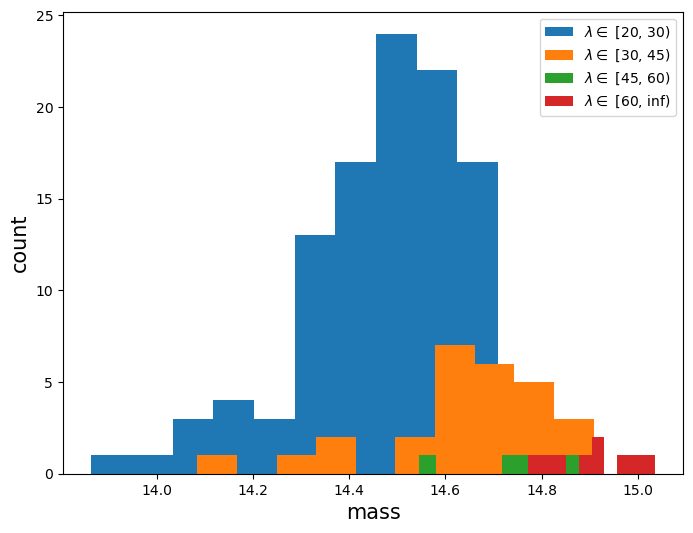

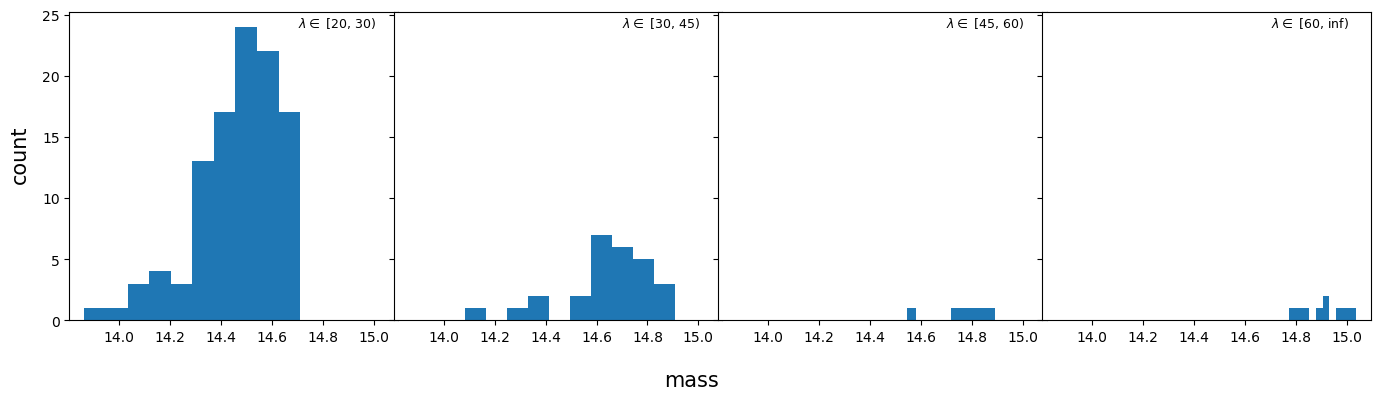

In [10]:
sel = [sel0, sel1, sel2, sel3]
bins = ['[20, 30)', '[30, 45)', '[45, 60)', '[60, inf)']
plt.rcParams['figure.figsize'] = (8,6)
# plt.xscale("log")
plt.hist(np.log10(true_mass[sel0]), label = f"$\lambda \in$ {bins[0]}")
plt.hist(np.log10(true_mass[sel1]), label = f"$\lambda \in$ {bins[1]}")
plt.hist(np.log10(true_mass[sel2]), label = f"$\lambda \in$ {bins[2]}")
plt.hist(np.log10(true_mass[sel3]), label = f"$\lambda \in$ {bins[3]}")
plt.xlabel("mass", fontsize=15)
plt.ylabel("count", fontsize=15)
plt.legend()
plt.show()

fig, axes = plt.subplots(1, 4, figsize=(14, 4), sharey=True, sharex = True)
for j in range(4):
    axes[j].hist(np.log10(true_mass[sel[j]]), label = f"$\lambda \in$ {bins[j]}")
    axes[j].text(14.7, 24.0, f"$\lambda \in$ {bins[j]}", fontsize = 9)
    
fig.supxlabel(r"mass", fontsize=15)
fig.supylabel(r"count", x = 0.02, y = 0.6, va='center', ha='center', fontsize=15)

# Adjust spacing between subplots
plt.tight_layout(h_pad = -1.0, w_pad = -1.1)
plt.show()

# axes[i, j].text(0.120, 100.0, f"$\lambda \in$ {halos_ds['lambda_range'][k]}", fontsize = 9)

### Adding systematics to data

In [11]:
mass_dic = {"l3_z0": mean_mass_true0, "l4_z0": mean_mass_true1, "l5_z0": mean_mass_true2, "l6_z0": mean_mass_true3} #3 = 3rd richness bin, in that order.
Sigma_dic = {"l3_z0": Sigma0, "l4_z0": Sigma1, "l5_z0": Sigma2, "l6_z0": Sigma3} #3 = 3rd richness bin, in that order.
DeltaSigma_dic = {"l3_z0": DeltaSigma0, "l4_z0": DeltaSigma1, "l5_z0": DeltaSigma2, "l6_z0": DeltaSigma3} #3 = 3rd richness bin, in that order.
# DeltaSigma_dic["l3_z0"]

In [12]:
from classy import Class
import cluster_toolkit as ctk
from colossus.cosmology import cosmology
from scipy.stats import norm#, multivariate_normal

#Start by specifying the cosmology
cosmo_params = {'flat': True, 'H0': 67.74, 'Om0': 0.3089, 'Ob0': 0.0486, 'sigma8': 0.8159, 'ns': 0.9667}
cosmology.addCosmology('MiniUchuu', cosmo_params)
cosmo = cosmology.setCosmology('MiniUchuu')

Omega_b = cosmo_params['Ob0']
Omega_m = cosmo_params['Om0']
Omega_cdm = Omega_m - Omega_b
sigma8 = cosmo_params['sigma8']
h = cosmo_params['H0']/100 # McClintock h value
A_s = 2.1e-9 #np.exp(3.064)/1e10 NB: ln(1e10*As)=3.064
n_s = cosmo_params['ns']
# z = 0.3

#Create a params dictionary
#Need to specify the max wavenumber
k_max = 1000 #UNITS: 1/Mpc

params = {
         'output':'mPk',
         'h':h,
         'sigma8':sigma8,
         'n_s':n_s,
         'Omega_b':Omega_b,
         'Omega_cdm':Omega_cdm,
         'P_k_max_1/Mpc':k_max,
         'z_max_pk':1.0, #Default value is 10
         'non linear':'halofit'
}

#Initialize the cosmology and compute everything
cosmo_ctk = Class()
cosmo_ctk.set(params)
cosmo_ctk.compute()

In [13]:
rp = np.array([ 0.04221139,  0.06651455,  0.10516441,  0.16537565,  0.26069825, 
               0.41202975,  0.65045543,  1.02563815,  1.61857299,  2.55379112, 
               4.02731114,  6.34991963, 10.00980414, 15.784786  , 24.87216972])
def add_sys_to_data(DS_data08):
    DS_data_final_raw = ctk.averaging.average_profile_in_bins(Redges, Rproj, DS_data08)
    DS_data_final_raw *= h*(1+z)**2 #convert to Msun/pc^2 physical
    return DS_data_final_raw


In [14]:
# DeltaSigma0[:-1]

c 5.6049482575055585
[318.48476447 296.96925458 284.78791904 249.63098925 195.10391796
 145.83043575 107.51049843  77.84952597  52.73633131  31.6391092
  16.08599081   8.09339679   4.43913989   2.52522278   1.97262286]
[308.82605598 296.6974379  276.41869222 245.87543362 205.34336038
 158.74689232 112.70903876  73.48767014  44.27871378  24.84426665
  12.80402446   6.42602142   3.58791395   2.25168628   1.50630847] 

c 5.445474165509438
[454.57362017 388.05266292 345.41781931 277.02254828 238.8989804
 179.80796984 140.00916961  99.21461047  66.66982113  42.90173873
  22.14846288  11.36890798   6.90454694   3.48147401   2.73352727]
[343.87602927 332.99104098 314.19427255 284.73344999 243.71574067
 193.98553502 142.08191951  95.48745446  59.13713883  34.02224225
  18.13259033   8.99068167   4.83895228   2.93180295   1.91134248] 

c 5.347209638313637
[236.99572581 340.26406718 408.00851525 316.50504459 268.08574978
 222.79923247 163.77609221 112.99557415  89.8617462   55.63854438
  30.7328

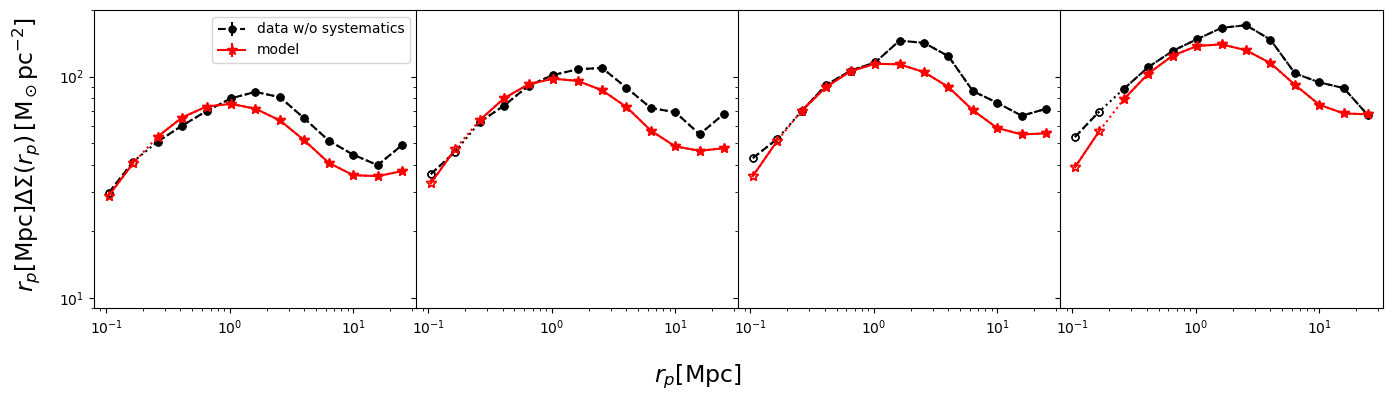

In [15]:
from cluster_toolkit import miscentering

# saved_file_path = r"/bsuhome/tnde/Lensing/data/"
converted_mini_uchuu = {}

saved_profiles_dic = "/bsuhome/tnde/Lensing/data/mini_uchuu_ds_cylinder_richness_selection_d30_no_pecvel_changing_vol_heidi_no_sys_final2.npy"

z = 0.3
a = 1/(1+z)
a2 = a**2

#Specify k and z
k = np.logspace(-5, np.log10(k_max), num=4000) #Mpc^-1 comoving

# Power spectrum
Pnonlin = np.array([cosmo_ctk.pk(ki, z) for ki in k])#*h**3  #Mpc^3/h^3 comoving
Plin = np.array([cosmo_ctk.pk_lin(ki, z) for ki in k])#*h**3  #Mpc^3/h^3 comoving
kh = k/h #h/Mpc comoving

#P(k) are in Mpc^3/h^3 comoving
#Thus, you will need to convert these to h/Mpc and (Mpc/h)^3 to use in the toolkit.
Plin *= h**3
Pnonlin *= h**3

# Create a figure and four subplots (1 row, 4 columns)
drop = 1
fig, axes = plt.subplots(1, 4, figsize=(14, 4), sharey=True, sharex = True)
# files_list = []
for j in range(4):
    ########################################### 
    # parameters
    lam_z_bin = "l"+str(j+3)+"_z0"
    mass = mass_dic[lam_z_bin]
    c = concentration.concentration(M=mass, mdef='200m', z=z, model = 'bhattacharya13') # 'bhattacharya13', 'bullock01'
    print("c", c)
    # c = 5.81 #c_dic[lam_z_bin]
    
    Rproj = np.logspace(-2, 2.4, num=1000, base=10) #Mpc/h Projected 2D radii. 
    R3d = np.logspace(-2, 3, num=1000, base=10) #Mpc/h comoving. 3D radii.
    
    # rp in comoving Mpc/h
    Rmin = 0.0323 
    Rmax = 30 
    nbins = 15
    
    # rp1 = rp_
    Redges = np.logspace(np.log10(Rmin), np.log10(Rmax), nbins+1) #Projected radial bin edges
    Redges *= h*(1+z) #Converted to Mpc/h comoving
    
    ##############################
    # Incorporating systematic effects into the simulated profiles
    Sigma_data08 = Sigma_dic[lam_z_bin] # Sigma profile
    DS_data08 = DeltaSigma_dic[lam_z_bin] # DeltaSigma profile
    # DS_data_final_raw = add_sys_to_data(DS_data08)
    DS_data_final_raw = ctk.averaging.average_profile_in_bins(Redges, Rproj, DS_data08)
    DS_data_final_raw *= h*(1+z)**2 #convert to Msun/pc^2 physical
    ##############################
    converted_mini_uchuu[lam_z_bin] = DS_data_final_raw
    # load_profiles_dic = np.load(saved_profiles_dic, allow_pickle=True).item()
    # DS_data8 = load_profiles_dic[lam_z_bin]
    ##############################
    
     # Compute boost factors from cluster toolkit
    #Note: Rs is default in Mpc physical
    # boost_model = ctk.boostfactors.boost_nfw_at_R(Rproj, B0, Rs*h*(1+z)) #theory
    
    # NFW profile
    xi_nfw = ctk.xi.xi_nfw_at_r(R3d, mass, c, Omega_m)
    
    # Matter-matter correlation function (matter auto-correlation)
    # xi_mm = xi.xi_mm_at_r(r, k, Plin)
    xi_mm = ctk.xi.xi_mm_at_r(R3d, kh, Pnonlin)
    
     # 2-halo correlation function
    bias_term = ctk.bias.bias_at_M(mass, kh, Plin, Omega_m) # Here, P must be linear.
    xi_2halo = ctk.xi.xi_2halo(bias_term, xi_mm)
    
    # Halo-matter correlation function
    xi_hm = ctk.xi.xi_hm(xi_nfw, xi_2halo)
    
    # Sigma (computed from xi_hm)
    Sigma = ctk.deltasigma.Sigma_at_R(Rproj, R3d, xi_hm, mass, c, Omega_m) #Sigma
    
    # DeltaSigma (excess surface density)
    # mass = mass/h
    DS_theory = ctk.deltasigma.DeltaSigma_at_R(Rproj, Rproj, Sigma, mass, c, Omega_m) #DeltaSigma
    # print(DS_theory)
    ave_DS = ctk.averaging.average_profile_in_bins(Redges, Rproj, DS_theory)
    ave_DS *= h*(1+z)**2 #convert to Msun/pc^2 physical

    # print(DS_data, "\n")
    print(DS_data_final_raw)
    print(ave_DS, "\n")
    # cap = rp1[-1]

    # print(ds)
    # print(ave_DS, "\n")
    inds1 = (rp >= 0.20)*(rp < 999) 
    inds2 = (rp >= 0.1)*(rp < 0.2) 
    inds3 = (rp >= 0.10)*(rp < 999) 
    # inds = rp > 0.0
    rp1 = rp[inds1]
    rp2 = rp[inds2]
    rp3 = rp[inds3]
    label = ["data w/o systematics", "model"]
    axes[j].loglog()

    ########################
    axes[j].set_ylim(9.0, 2e2)
    # axes[j].set_ylim(0.4, 3.5e2)
    axes[j].errorbar(rp1, rp1*DS_data_final_raw[inds1], yerr = np.zeros(len(rp1)), 
                     fmt = '--o', ms = 5.0, color = 'black', label = label[0]) #:*, -.*, --*, -*
    axes[j].errorbar(rp2, rp2*DS_data_final_raw[inds2], yerr = np.zeros(len(rp2)), 
                     fmt = '--o', ms = 5.0, color = 'black', fillstyle='none') #:*, -.*, --*, -*
    axes[j].errorbar(rp3, rp3*DS_data_final_raw[inds3], yerr = np.zeros(len(rp3)), 
                     fmt = ':o', ms = 5.0, color = 'black', fillstyle='none') #:*, -.*, --*, -*
    
    axes[j].errorbar(rp1, rp1*ave_DS[inds1], yerr = np.zeros(len(rp1)), 
                     fmt = '-*', ms = 7.0, color = 'red', label = label[1])
    axes[j].errorbar(rp2, rp2*ave_DS[inds2], yerr = np.zeros(len(rp2)), 
                     fmt = '-*', ms = 7.0, color = 'red', fillstyle='none')
    axes[j].errorbar(rp3, rp3*ave_DS[inds3], yerr = np.zeros(len(rp3)), 
                     fmt = ':*', ms = 7.0, color = 'red', fillstyle='none')
    
    if j == 0:
        axes[j].legend()
        
# Add a super title, super x label, and super y label
# fig.suptitle(r'$\Delta\Sigma$ Profiles', fontsize=20)
fig.supxlabel(r"$\rm \mathit{r_p} [Mpc]$", fontsize=17)
# fig.supylabel(r"$\rm \Delta\Sigma\,[M_\odot \mathrm{pc}^{-2}]$", fontsize=15)
fig.supylabel(r"$\rm \mathit{r_p} [Mpc] \Delta\Sigma(\mathit{r_p})\,[M_\odot \mathrm{pc}^{-2}]$", x = 0.02, y = 0.6, va='center', ha='center', fontsize=17)

# Adjust spacing between subplots
plt.tight_layout(h_pad = -1.0, w_pad = -0.6)
plt.show()

# np.save(saved_profiles_dic, converted_mini_uchuu)